## IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd

from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pickle

## LOAD DATASET

In [2]:
df = pd.read_csv('ner_dataset.csv', encoding="latin1")

In [3]:
df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [5]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 12073,the,NN,O
freq,1,52573,145807,887908


In [6]:
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

Unique NER tags are as follows:
* O   : other
* geo : Geographical Entity
* gpe : Geopolitical Entity
* org : Organization
* per : Person
* tim : Time indicator
* art : Artifact
* eve : Event
* nat : Natural Phenomenon

In [7]:
# Percentage of each class label
df['Tag'].value_counts() / len(df) * 100

O        84.677586
B-geo     3.590015
B-tim     1.939108
B-org     1.920988
I-per     1.645185
B-per     1.620294
I-org     1.600648
B-gpe     1.513483
I-geo     0.707055
I-tim     0.622559
B-art     0.038338
B-eve     0.029373
I-art     0.028324
I-eve     0.024128
B-nat     0.019169
I-gpe     0.018883
I-nat     0.004864
Name: Tag, dtype: float64

**Observation**: Most of the labels are "O" (Other) which means we are dealing with imbalanced dataset.

## HANDLE MISSING VALUES

In [8]:
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

**Observation**: There are missing values in sentence column, we need to fill each missing value with the nearest-top valid value.

In [9]:
df['Sentence #'] = df['Sentence #'].fillna(method='ffill')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [10]:
# Dropped since we don't need this column
df.drop('POS', axis=1, inplace=True)

In [11]:
df.isnull().sum()

Sentence #    0
Word          0
Tag           0
dtype: int64

## GENERATE NESTED-SENTENCES LIST

In [12]:
# Get list of sentences and tags
sentences = df.groupby("Sentence #")["Word"].apply(list).values
tags = df.groupby("Sentence #")["Tag"].apply(list).values

In [13]:
# Create a pair of (word, tag) inside each sentence
paired_sentences = []
for i in range(len(sentences)):
    sent_pair = list(zip(sentences[i],tags[i]))
    paired_sentences.append(sent_pair)

In [14]:
# Sample sentence
paired_sentences[18]

[('Doctors', 'O'),
 ('say', 'O'),
 ('they', 'O'),
 ('expect', 'O'),
 ('Mr.', 'B-per'),
 ('Sharon', 'I-per'),
 ('will', 'O'),
 ('make', 'O'),
 ('a', 'O'),
 ('full', 'O'),
 ('recovery', 'O'),
 ('.', 'O')]

## EXTRACT FEATURES (ENCODING)

In [15]:
#Get vocabulary from unique words and unique tags
unique_words = df["Word"].unique().tolist()
unique_words.append("ENDPAD")
unique_words.append("UNK")
num_words = len(unique_words)

unique_tags = df["Tag"].unique().tolist()
num_tags = len(unique_tags)

In [16]:
# Create word-to-index and tags-to-index dictionaries
word2index = {w: i for i, w in enumerate(unique_words)}
tag2index = {t: i for i, t in enumerate(unique_tags)}

In [17]:
# Encode each (word,tag) pair using the above dictionaries
X = [[word2index[w[0]] for w in s] for s in paired_sentences]
y = [[tag2index[w[1]] for w in s] for s in paired_sentences]

In [18]:
# Choose the max_len as the longest sentence's length
max_len = max([len(s) for s in paired_sentences])

In [19]:
# Apply padding to each word-vector (to ensure same size for each)
X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=word2index["ENDPAD"])
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2index["O"])

In [20]:
# Convert labels to one-hot vector
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [21]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## CREATE RNN MODEL

In [21]:
# RNN Model
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 104)          3658720   
_________________________________________________________________
dropout (Dropout)            (None, 104, 104)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          86528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           2193      
Total params: 3,747,441
Trainable params: 3,747,441
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
earlyStop = EarlyStopping(monitor='val_loss', patience=2)
checkpointer = ModelCheckpoint(filepath='ner_rnn.h5', save_best_only=True)

In [25]:
history = model.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2, 
                    callbacks=[earlyStop, checkpointer])

Epoch 1/10
960/960 [==============================] - 165s 166ms/step - loss: 0.2985 - accuracy: 0.9593 - val_loss: 0.0428 - val_accuracy: 0.9885
Epoch 2/10
960/960 [==============================] - 172s 179ms/step - loss: 0.0353 - accuracy: 0.9902 - val_loss: 0.0277 - val_accuracy: 0.9919
Epoch 3/10
960/960 [==============================] - 184s 191ms/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.0254 - val_accuracy: 0.9924
Epoch 4/10
960/960 [==============================] - 195s 203ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0249 - val_accuracy: 0.9928
Epoch 5/10
960/960 [==============================] - 203s 212ms/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.0253 - val_accuracy: 0.9928
Epoch 6/10
960/960 [==============================] - 202s 210ms/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.0258 - val_accuracy: 0.9927


## EVALUATE PERFORMANCE OF TEST SET

<AxesSubplot:>

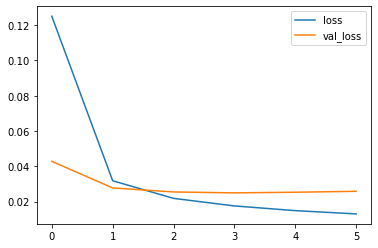

In [47]:
# Plot the losses
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot()

In [26]:
# Make predictions
y_pred = model.predict(X_test)
# Choose class with maximum probability
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

In [27]:
# Create index-to-tag dictionary
index2tag = {i: t for t, i in tag2index.items()}

In [28]:
# Convert each indices back to tags
y_pred = [[index2tag[y] for y in y_s] for y_s in y_pred]
y_true = [[index2tag[y] for y in y_s] for y_s in y_true]

In [29]:
# Print evaluation metrics and classification report
print("Accuracy score : {:.1%}".format(accuracy_score(y_true, y_pred)))
print("Precision score: {:.1%}".format(precision_score(y_true, y_pred)))
print("Recall score   : {:.1%}".format(recall_score(y_true, y_pred)))
print("F1-score       : {:.1%}".format(f1_score(y_true, y_pred)))

Accuracy score : 99.3%
Precision score: 79.9%
Recall score   : 80.9%
F1-score       : 80.4%


In [30]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        72
         eve       0.39      0.26      0.31        58
         geo       0.85      0.86      0.85      7543
         gpe       0.96      0.93      0.95      3111
         nat       0.32      0.32      0.32        28
         org       0.63      0.69      0.66      3956
         per       0.74      0.71      0.72      3425
         tim       0.83      0.85      0.84      3998

   micro avg       0.80      0.81      0.80     22191
   macro avg       0.59      0.58      0.58     22191
weighted avg       0.80      0.81      0.80     22191



In [31]:
# Save the necessary objects for making new predictions as pickle file
obj = {'word2index': word2index, 'tag2index': tag2index, 'index2tag': index2tag, 
       'num_tags': num_tags, 'unique_words': unique_words}

with open("saved_objects.dat", "wb") as f:
    pickle.dump(obj, f)

## MAKE PREDICTION FOR NEW OBSERVATION

In [30]:
# Use this if you don't want to re-train the model
#with open("saved_objects.dat", "rb") as f:
#    saved_obj = pickle.load(f)
#word2index = saved_obj['word2index'] 
#tag2index = saved_obj['tag2index']  
#index2tag = saved_obj['index2tag']  
#num_tags = saved_obj['num_tags']  
#unique_words = saved_obj['unique_words']

In [22]:
new_sentence = ['Mr.', 'Huseyin', 'said', 'the', 'latest', 'figures', 'show', '1.8', 'million', 'people', 
                'are', 'in', 'need', 'of', 'food', 'assistance', '-', 'with', 'the', 'need', 'greatest', 
                'in', 'Indonesia', ',', 'the', 'Maldives', 'and', 'India', '.']

In [23]:
new_tags = ['B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
            'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O']

In [24]:
# Convert each word and label into index
sample_x = [word2index.get(word, word2index['UNK']) for word in new_sentence]
sample_y = [tag2index.get(tag, tag2index["O"]) for tag in new_tags]

In [25]:
# Apply padding and one-hot vectorization
sample_x.extend([word2index["ENDPAD"]] * (max_len - len(sample_x)))
sample_y.extend([tag2index["O"]] * (max_len - len(sample_y)))
sample_y = [to_categorical(i, num_classes=num_tags) for i in sample_y]

In [29]:
# Load the pre-trained model
model = load_model('ner_rnn.h5')

In [39]:
# Make prediction and get true labels
pred = model.predict(np.array([sample_x]))
pred = np.squeeze(np.argmax(pred, axis=-1))
true = np.argmax(np.array(sample_y), axis=-1)

In [39]:
# Show predictions
print("{:12}| {:6}| {}".format("Word", "True", "Pred"))
print(30 * "-")
for w, t, p in zip(np.array(sample_x), true, pred):
    if unique_words[w] != 'ENDPAD':
        print("{:12}: {:6} {}".format(unique_words[w], index2tag[t], index2tag[p]))

Word        | True  | Pred
------------------------------
Mr.         : B-per  B-per
UNK         : I-per  I-per
said        : O      O
the         : O      O
latest      : O      O
figures     : O      O
show        : O      O
1.8         : O      O
million     : O      O
people      : O      O
are         : O      O
in          : O      O
need        : O      O
of          : O      O
food        : O      O
assistance  : O      O
-           : O      O
with        : O      O
the         : O      O
need        : O      O
greatest    : O      O
in          : O      O
Indonesia   : B-geo  B-geo
,           : O      O
the         : O      O
Maldives    : B-geo  B-geo
and         : O      O
India       : B-geo  B-geo
.           : O      O


**OBSERVATION**: Note that even the word "Huseyin" (UNK-Unknown Word) is not on the vocabulary list, my model has succesfully predict it's NER as "Person"